In [3]:
import data_loading_code as loader

#### **Load data loader**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        new_row = pd.DataFrame([{
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent)
        }])
        df_ = pd.concat([df_, new_row], ignore_index=True)
    return data

# If this is the primary file that is executed (ie not an import of another file)

# get data, pre-process and split
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process
training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.10,
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


#### **Create chatbot**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [24]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}')
    
    return train_losses  
def validate(model, validation_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    validation_loss = total_loss / len(validation_loader)
    print(f'Validation Loss: {validation_loss:.4f}')
    return validation_loss

Epoch 1, Training Loss: 0.6926
Validation Loss: 0.6912
Epoch 1, Training Loss: 0.6855
Validation Loss: 0.6792
Epoch 1, Training Loss: 0.6566
Validation Loss: 0.6437
Epoch 1, Training Loss: 0.5709
Validation Loss: 0.5544
Epoch 1, Training Loss: 0.3891
Validation Loss: 0.4250
Epoch 1, Training Loss: 0.1905
Validation Loss: 0.3306
Epoch 1, Training Loss: 0.0691
Validation Loss: 0.3092
Epoch 1, Training Loss: 0.0263
Validation Loss: 0.3112
Epoch 1, Training Loss: 0.0149
Validation Loss: 0.3244
Epoch 1, Training Loss: 0.0080
Validation Loss: 0.3399


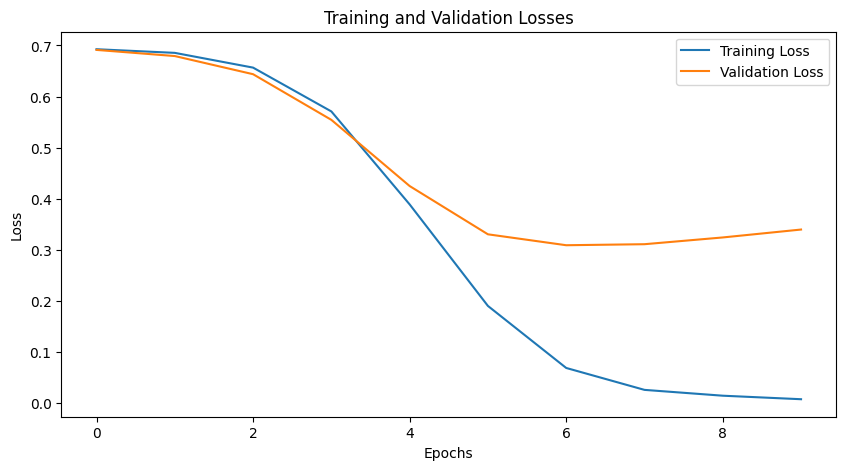

In [25]:
from torch.utils.data import TensorDataset, DataLoader

model = TextClassifier(input_dim=vocab_size, hidden_dim=100, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 10
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, 1)  
    validation_loss = validate(model, validation_loader, criterion)
    train_losses.extend(train_loss)  
    validation_losses.append(validation_loss)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### **It seems like a model trained during 6 epochs is providing the best results, and after it start to overfit**

In [32]:
model = TextClassifier(input_dim=vocab_size, hidden_dim=100, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 6
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, 1)  
    validation_loss = validate(model, validation_loader, criterion)
    train_losses.extend(train_loss)  
    validation_losses.append(validation_loss)

torch.save(model.state_dict(), 'model_state_dict.pth')
torch.save(optimizer.state_dict(), 'optimizer_state_dict.pth')

Epoch 1, Training Loss: 0.6912
Validation Loss: 0.6905
Epoch 1, Training Loss: 0.6859
Validation Loss: 0.6772
Epoch 1, Training Loss: 0.6505
Validation Loss: 0.6330
Epoch 1, Training Loss: 0.5410
Validation Loss: 0.5257
Epoch 1, Training Loss: 0.3466
Validation Loss: 0.3944
Epoch 1, Training Loss: 0.1464
Validation Loss: 0.3211


In [35]:

model = TextClassifier(input_dim=vocab_size, hidden_dim=100, output_dim=2)
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()  # Set the model to evaluation mode if you're loading for inference

# If also loading the optimizer state (useful for resuming training)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(torch.load('optimizer_state_dict.pth'))

In [40]:
def main_loop(model, vocab, prompts):
    model.eval()  # Evaluation mode
    while True:
        prompt = random.choice(prompts)  # Randomly choose a prompt
        print("Bot:", prompt)
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break

        input_tensor = text_to_tensor(user_input, vocab)  # Convert input to tensor
        with torch.no_grad():
            output = model(input_tensor)
            response = tensor_to_text(output, vocab)  # Decode tensor to text

        print("Bot:", response)

def text_to_tensor(text, vocab):
    # Assume the least frequent word is 'the' and you decide to use its index for all OOV words
    default_idx = vocab.get('the')  # Use an actual word's index as default for OOV words
    indices = [vocab.get(word, default_idx) for word in text.split()]  # Use default index for OOV words
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0)  # Add batch dimension
    return tensor.float()

# Example of converting tensor output to text
def tensor_to_text(tensor, vocab):
    idx_to_word = {idx: word for word, idx in vocab.items()}  # Reverse the vocabulary dictionary
    indices = tensor.argmax(1).tolist()  # Convert to list for indexing
    return ' '.join(idx_to_word[idx] for idx in indices if idx in idx_to_word)  # Join words by space

In [41]:
prompts = ["Hello, how can I help you today?", 
           "Can you tell me more about your issue?", 
           "What else can I assist you with?", 
           "Are you looking for help with a product or service?"]
vocab = word_vectorizer.vocabulary_
main_loop(model, vocab, prompts)

Bot: Hello, how can I help you today?


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float